## Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from gan import preprocessing, tadgan, postprocessing, utils

In [2]:
# set constants and hyperparameters

DATASET = 'data/2023_quy1.csv'
DATASET_TEST = 'data/2023_quy1_test.csv'
# Minimum value: 20.5
# Maximum value: 32.5
# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 70

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [3]:
# import time series

x = pd.read_csv(DATASET)

# x['time'] = pd.to_datetime(x['time'],format="%d-%m-%Y %H:%M:%S", dayfirst=True)
x.set_index('time', inplace=True)
x.index = pd.to_datetime(x.index)
x.sort_index(inplace=True)

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

x.describe()

temp = x['temperature']
# temp = temp[temp>=18]
# temp = temp.resample('H').mean()

train = temp[(temp.index.year>=2022)]
# test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

train.head()

Number of time stamps: 10811
First 3 time stamps: 2023-01-01 00:17:01, 2023-01-01 00:19:03, 2023-01-01 00:41:58
Last 3 time stamps: 2023-03-27 20:50:42, 2023-03-27 21:14:50, 2023-03-27 21:25:27


time
2023-01-01 00:17:01    22.1
2023-01-01 00:19:03    22.9
2023-01-01 00:41:58    22.9
2023-01-01 00:43:16    21.9
2023-01-01 01:04:53    22.9
Name: temperature, dtype: float64

## Prepare Training Data


In [4]:
# apply preprocessing pipeline

train, t, x_win, t_win = preprocessing.new_apply_pipeline(train, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

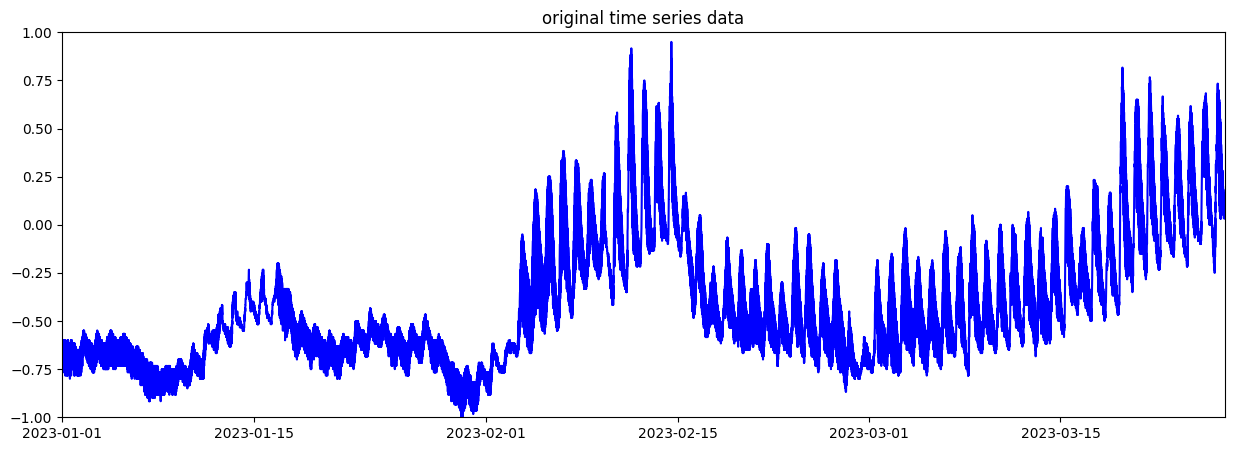

In [5]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=None, 
                       date_range=['2023-01-01', '2023-03-27'], value_range=[-1, 1],
                       title='original time series data')

In [6]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 10712
Start times of the first 3 windows: ['2023-01-01T00:17:01.000000000' '2023-01-01T00:19:03.000000000'
 '2023-01-01T00:41:58.000000000']


## Train Reconstruction Model (TadGAN)

In [7]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [8]:
# train the model

t0 = time.time()
model.fit(x_win, epochs=EPOCHS)
t1 = time.time()

model.save_model("./model/model_tran_70_quy1_loss")

Epoch 1/70 (129.6 secs)
  Critic X Loss: -0.130422 [-3.53304192  1.36050382  0.20421162]
  Critic Z Loss: 3.055700 [-0.35316761  1.02517129  0.23836965]
  Encoder Generator Loss: 0.464992 [-1.33334199  0.03357106  0.17647625]
Epoch 2/70 (86.6 secs)
  Critic X Loss: -0.974269 [-0.08445783 -1.24922966  0.0359419 ]
  Critic Z Loss: -7.243756 [ 0.33454501 -9.25279427  0.16744931]
  Encoder Generator Loss: 13.447800 [ 1.46905463 10.05293599  0.19258095]
Epoch 3/70 (80.4 secs)
  Critic X Loss: -1.548221 [-5.65209633  3.82706288  0.02768124]
  Critic Z Loss: 0.636498 [ 0.45733582 -0.99178726  0.11709496]
  Encoder Generator Loss: -1.806527 [-3.78196557  1.14495246  0.08304862]
Epoch 4/70 (80.2 secs)
  Critic X Loss: -0.936821 [-3.40472923  2.17558185  0.02923268]
  Critic Z Loss: 1.375969 [ 0.50329973 -0.34672066  0.12193902]
  Encoder Generator Loss: -0.290869 [-2.02848907  0.59762217  0.11399982]
Epoch 5/70 (93.6 secs)
  Critic X Loss: -0.883087 [-4.73838032  3.66462731  0.01906661]
  Criti

INFO:tensorflow:Assets written to: ./model/model_tran_70_quy1_loss_encoder\assets


INFO:tensorflow:Assets written to: ./model/model_tran_70_quy1_loss_encoder\assets


INFO:tensorflow:Assets written to: ./model/model_tran_70_quy1_loss_generator\assets


INFO:tensorflow:Assets written to: ./model/model_tran_70_quy1_loss_generator\assets


INFO:tensorflow:Assets written to: ./model/model_tran_70_quy1_loss_critic_x\assets


INFO:tensorflow:Assets written to: ./model/model_tran_70_quy1_loss_critic_x\assets


INFO:tensorflow:Assets written to: ./model/model_tran_70_quy1_loss_critic_z\assets


INFO:tensorflow:Assets written to: ./model/model_tran_70_quy1_loss_critic_z\assets


In [8]:
model.get_model("./model/model_tran_100_quy1")

In [9]:
print(f'Total training time for {EPOCHS} epochs: {t1 - t0:.1f} secs')

Total training time for 70 epochs: 5994.2 secs


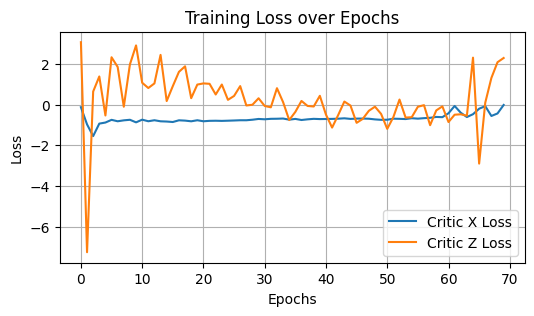

In [11]:
critic_x_loss_history, critic_z_loss_history, encoder_generator_loss_history = model.getLoss()
critic_x_total_loss = [loss[0] for loss in critic_x_loss_history]
critic_z_total_loss = [loss[0] for loss in critic_z_loss_history]
encoder_generator_total_loss = [loss[0] for loss in encoder_generator_loss_history]

plt.figure(figsize=(6, 3))
plt.plot(critic_x_total_loss, label='Critic X Loss')
plt.plot(critic_z_total_loss, label='Critic Z Loss')
# plt.plot(encoder_generator_total_loss, label='Encoder Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print(x_win)

[[-0.73333333 -0.6        -0.6        ... -0.75       -0.61666667
  -0.75      ]
 [-0.6        -0.6        -0.76666667 ... -0.61666667 -0.75
  -0.61666667]
 [-0.6        -0.76666667 -0.6        ... -0.75       -0.61666667
  -0.75      ]
 ...
 [-0.01666667  0.01666667 -0.01666667 ...  0.16666667  0.48333333
   0.16666667]
 [ 0.01666667 -0.01666667 -0.01666667 ...  0.48333333  0.16666667
   0.18333333]
 [-0.01666667 -0.01666667  0.01666667 ...  0.16666667  0.18333333
   0.45      ]]


In [12]:
# generate reconstructed time series segments
x_win_recon, critic_scores = model.predict(x_win)

In [22]:
print(x_win_recon)
print(len(x_win_recon))

[[-0.712169   -0.63242006 -0.6987239  ... -0.61287475 -0.6385426
  -0.6110431 ]
 [-0.7104908  -0.63182855 -0.6976069  ... -0.6120734  -0.6373476
  -0.6100833 ]
 [-0.71175915 -0.63225734 -0.6984344  ... -0.6126282  -0.6383413
  -0.61080694]
 ...
 [ 0.0871473   0.07513841  0.12290174 ...  0.14693011  0.16093308
   0.17810354]
 [ 0.08979023  0.0781244   0.12646876 ...  0.1361164   0.15065642
   0.16759804]
 [ 0.09571117  0.08417609  0.13228367 ...  0.12833464  0.14331755
   0.16013789]]
10712


In [14]:
print(critic_scores)

[6.529379  6.5057898 6.5362325 ... 8.135206  8.183654  8.173998 ]


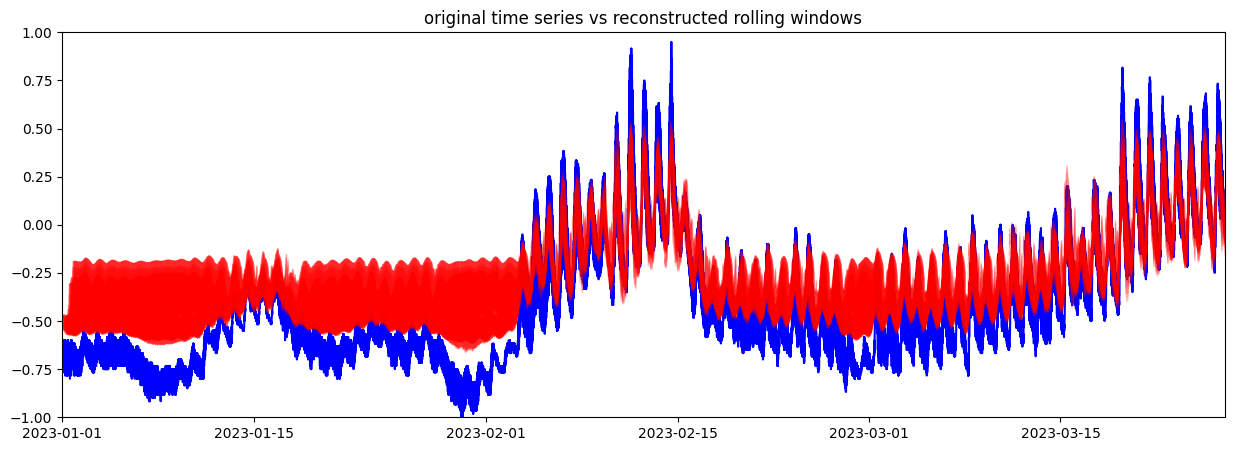

In [13]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=x_win_recon, 
                       date_range=['2023-01-01', '2023-03-27'], value_range=[-1, 1],
                       title='original time series vs reconstructed rolling windows')

In [14]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(train, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

In [15]:
print(t)

['2023-01-01T00:17:01.000000000' '2023-01-01T00:19:03.000000000'
 '2023-01-01T00:41:58.000000000' ... '2023-03-27T20:50:42.000000000'
 '2023-03-27T21:14:50.000000000' '2023-03-27T21:25:27.000000000']


In [21]:
print(train)

[-0.73333333 -0.6        -0.6        ...  0.16666667  0.18333333
  0.45      ]


In [13]:
print(detected_intervals)

[['2023-01-29T17:56:35.000000000' '2023-01-31T01:55:04.000000000']
 ['2023-02-04T04:36:04.000000000' '2023-02-05T00:45:51.000000000']
 ['2023-02-11T05:00:04.000000000' '2023-02-12T03:44:32.000000000']]


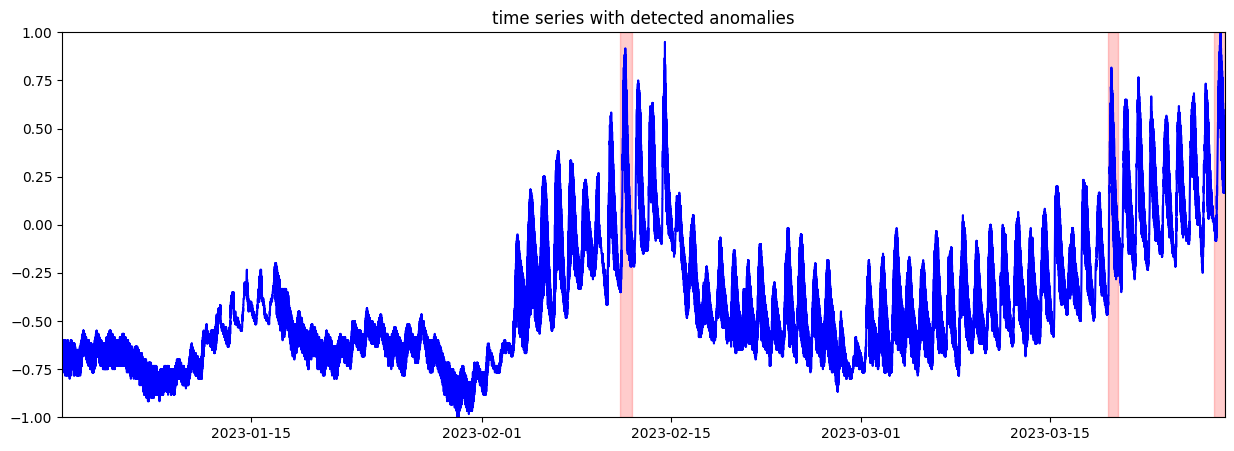

In [16]:
# plot time series with detected anomalies

utils.plot_time_series(t, train, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with detected anomalies')

In [34]:
test_model, t, x_win_test, t_win_test = preprocessing.new_apply_pipeline(test, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [35]:
x_win_recon_test, critic_scores_test = model.predict(x_win_test)

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(x_win_test, x_win_recon_test)
mae = mean_absolute_error(x_win_test, x_win_recon_test)
r2 = r2_score(x_win_test, x_win_recon_test)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R Squared (R2):", r2)

Mean Squared Error (MSE): 0.03469282217892352
Mean Absolute Error (MAE): 0.10864650637070725
R Squared (R2): 0.5192465415856207


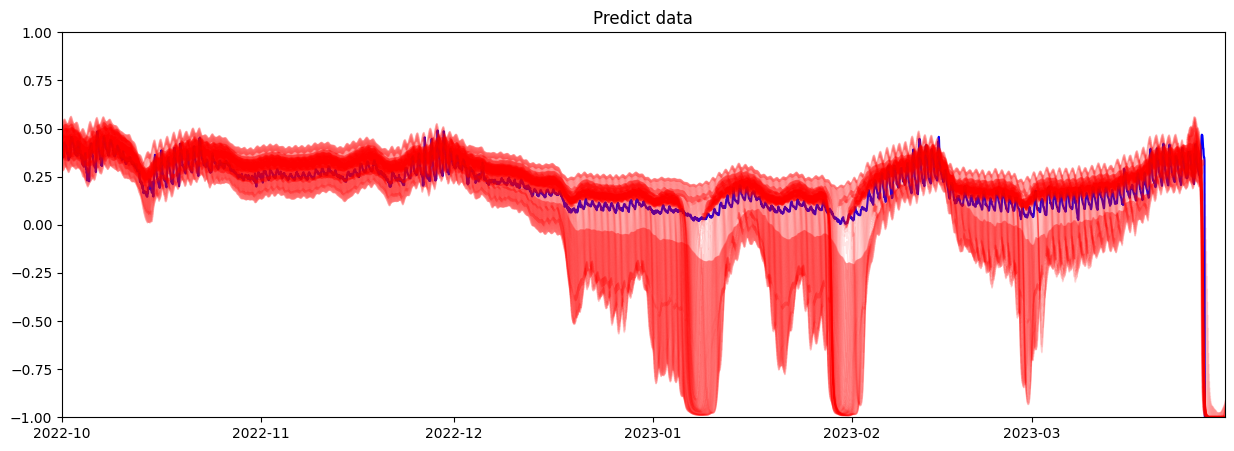

In [38]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, test_model, x_win=x_win_recon_test, 
                       date_range=['2022-10-01', '2023-03-31'], value_range=[-1, 1],
                       title='Predict data')

In [40]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(test_model, t, x_win_recon_test, critic_scores_test, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

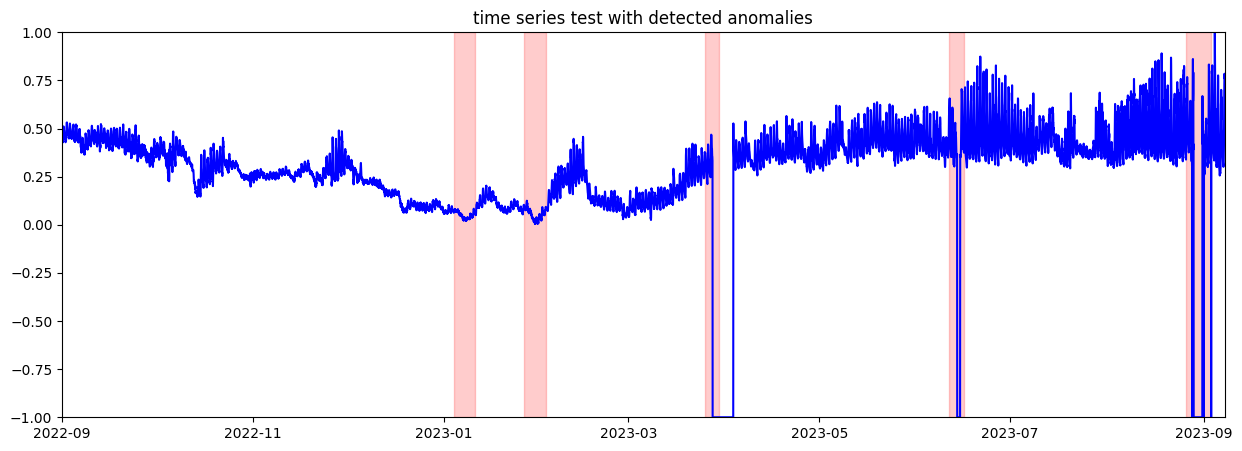

In [41]:
# plot time series with detected anomalies

utils.plot_time_series(t, test_model, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series test with detected anomalies')